In [399]:
%matplotlib inline
from collections import defaultdict

# Settings

In [400]:
PCT_TEST_SPLIT = 0.2

#Source Folder (essay_folder) - CHANGE THIS ONE SETTING TO SWITCH BETWEEN CB AND SC!!!!!

#essay_folder = "CoralBleaching/BrattData/EBA1415_Merged/"
essay_folder = "SkinCancer/EBA1415_Merged/"



data_dir = "/Users/simon.hughes/Google Drive/Phd/Data/"
folder = data_dir + essay_folder

root_folder = data_dir + essay_folder.split("/")[0] + "/Thesis_Dataset/"
print "Root: " + root_folder

all_folder      = root_folder + "All_Files/"
test_folder     = root_folder + "Test/"
training_folder = root_folder + "Training/"

print ""
for f in [all_folder, training_folder, test_folder]:
    print f

Root: /Users/simon.hughes/Google Drive/Phd/Data/SkinCancer/Thesis_Dataset/

/Users/simon.hughes/Google Drive/Phd/Data/SkinCancer/Thesis_Dataset/All_Files/
/Users/simon.hughes/Google Drive/Phd/Data/SkinCancer/Thesis_Dataset/Training/
/Users/simon.hughes/Google Drive/Phd/Data/SkinCancer/Thesis_Dataset/Test/


# Map .ann And .txt Files

In [363]:
import os, re

def find_files(folder, regex, remove_empty = False):
    """
    Find all files matching the [regex] pattern in [folder]

    folder  :   string
                    folder to search (not recursive)
    regex   :   string (NOT regex object)
                    pattern to match
    """
    files = os.listdir(folder)
    matches = [os.path.abspath(os.path.join(folder, f))
               for f in files
               if re.search(regex, f, re.IGNORECASE)]

    if remove_empty:
        matches = [f for f in matches if os.path.getsize(f) > 0]
    matches.sort()
    return matches

In [364]:
ann_files = find_files(folder, "\.ann$", remove_empty=True)
txt_files = find_files(folder, "\.txt$", remove_empty=True)
len(ann_files), len(txt_files)

(1107, 1114)

In [365]:
def get_prefix(fname):
    return fname[:-4]

dct_ann = defaultdict(set)
for ann in ann_files:
    prefix = get_prefix(ann)
    dct_ann[prefix].add(ann)

dct_txt = defaultdict(set)
for txt in txt_files:
    prefix = get_prefix(txt)
    dct_txt[prefix].add(txt)

len(dct_ann), len(dct_txt)

(1107, 1114)

### Joined Represents a Mapping Between Prefixes and (.ann,.txt) Filenames

In [366]:
joined = {}
for prfx in dct_ann.keys():
    if prfx in dct_txt:
        joined[prfx] = (dct_ann[prfx], dct_txt[prfx])
len(joined)

1107

# Load and Parse Actual The Essay Files (Removing Invalid and Empty Files)

In [370]:
%%time
from BrattEssay import load_bratt_essays
from collections import defaultdict
from IterableFP import flatten
from Settings import Settings
settings = Settings()
essays = load_bratt_essays(folder)

Results Dir: /Users/simon.hughes/Google Drive/Phd/Results/
Data Dir:    /Users/simon.hughes/Google Drive/Phd/Data/
Root Dir:    /Users/simon.hughes/GitHub/NlpResearch/
Public Data: /Users/simon.hughes/GitHub/NlpResearch/Data/PublicDatasets/
1107 files found
Skipping /Users/simon.hughes/Google Drive/Phd/Data/SkinCancer/EBA1415_Merged/EBA1415_BGJD_1_SC_ES-05728.ann file as .txt file is no essay'
Skipping /Users/simon.hughes/Google Drive/Phd/Data/SkinCancer/EBA1415_Merged/EBA1415_BGJD_1_SC_ES-5726_9.ann file as .txt file is no essay.'
Skipping /Users/simon.hughes/Google Drive/Phd/Data/SkinCancer/EBA1415_Merged/EBA1415_KYLS_6_SC_ES-05674.ann file as .txt file is no essay'
Skipping /Users/simon.hughes/Google Drive/Phd/Data/SkinCancer/EBA1415_Merged/EBA1415_LRJE_7_SC_ES-05142.ann file as .txt file is no essay'
Skipping /Users/simon.hughes/Google Drive/Phd/Data/SkinCancer/EBA1415_Merged/EBA1415_RDCS_1_SC_ES-04696.ann file as .txt file is no essay//'
Skipping /Users/simon.hughes/Google Drive/P

### Now Remove Invalid Files from the Joined List

In [371]:
valid_essays = set(map(lambda essay: get_prefix(essay.full_path), essays))
match = set((e for e in valid_essays if e in joined))
len(valid_essays), len(match), len(joined)

(1088, 1088, 1107)

In [372]:
deleted = 0
for e in list(joined.keys()):
    if e not in match:
        del joined[e]
        deleted+=1
print deleted, "Essays deleted"
print len(valid_essays), len(match), len(joined)

19 Essays deleted
1088 1088 1088


# Partition into Train and Test Sets

## 1. Calculate the Partition Sizes (in ints):

In [373]:
num = len(joined.keys())
n_test = int(round(PCT_TEST_SPLIT * len(joined.keys())))
print "Test:", n_test, "\tTrain:", num - n_test, "\tTotal:", num
print round(float(n_test) / num * 100,4), "%"

Test: 218 	Train: 870 	Total: 1088
20.0368 %


In [374]:
assert num == len(essays), "Total should match number of essays"

## 2. Create Partition, and Compute Code Distributions

### Compute Counts Across Whole Corpus

In [375]:
nm_wds = 0
num_sentences = 0
all_codes = set()
for essay in essays:
    for sentence in essay.tagged_sentences:
        num_sentences+=1
        for wd, tags in sentence:
            num_wds +=1
            all_codes.update(tags)
num_wds, num_sentences, len(all_codes)

(684521, 10670, 112)

### Segment Codes by Category

In [376]:
regular_codes = sorted([c for c in all_codes if c[0].isdigit()], key=lambda c: (len(c), c))
causal_codes = sorted([c for c in all_codes if "->" in c])
print "regular", regular_codes
print "causal", "\n".join(causal_codes)

regular ['1', '2', '3', '4', '5', '6', '11', '12', '50']
causal Causer:1->Result:2
Causer:1->Result:3
Causer:1->Result:4
Causer:1->Result:5
Causer:1->Result:50
Causer:1->Result:Anaphor
Causer:1->Result:rhetorical
Causer:11->Result:12
Causer:11->Result:3
Causer:11->Result:4
Causer:11->Result:5
Causer:11->Result:50
Causer:11->Result:Anaphor
Causer:12->Result:12
Causer:12->Result:2
Causer:12->Result:3
Causer:12->Result:4
Causer:12->Result:5
Causer:12->Result:50
Causer:12->Result:Anaphor
Causer:2->Result:1
Causer:2->Result:11
Causer:2->Result:2
Causer:2->Result:3
Causer:2->Result:4
Causer:2->Result:5
Causer:2->Result:50
Causer:2->Result:6
Causer:2->Result:Anaphor
Causer:2->Result:rhetorical
Causer:3->Result:11
Causer:3->Result:2
Causer:3->Result:4
Causer:3->Result:5
Causer:3->Result:50
Causer:3->Result:6
Causer:3->Result:Anaphor
Causer:3->Result:rhetorical
Causer:4->Result:11
Causer:4->Result:12
Causer:4->Result:4
Causer:4->Result:5
Causer:4->Result:50
Causer:4->Result:6
Causer:4->Result:A

In [377]:
def compute_tag_distributions(essays, codes=None):
    if not codes:
        codes = all_codes
    else:
        codes = set(codes)
        
    wd_tag_freq = defaultdict(int)
    sent_tag_freq = defaultdict(int)
    num_wds = 0
    num_sentences = 0
    for essay in essays:
        for sentence in essay.tagged_sentences:
            num_sentences+=1
            # compute unique tags for sentence for computing sentence distributions
            un_tags = set()
            for wd, tags in sentence:
                num_wds +=1
                tags = tags.intersection(codes)
                if not tags:
                    continue
        
                un_tags.update(tags)
                for tag in tags:
                    wd_tag_freq[tag] += 1
            for tag in un_tags:
                sent_tag_freq[tag] += 1
    
    for tag in wd_tag_freq.keys():
        wd_tag_freq[tag] = float(wd_tag_freq[tag])/ float(num_wds)
        sent_tag_freq[tag] = float(sent_tag_freq[tag] / float(num_sentences))
    
    return wd_tag_freq, sent_tag_freq

In [378]:
import pandas as pd
def to_df(freq_dct):
    return pd.DataFrame({"codes": freq_dct.keys(), "freq": freq_dct.values()}).sort_values("codes")

In [379]:
wd_freq, sent_freq = compute_tag_distributions(essays, regular_codes)
to_df(wd_freq)

,codes,freq
3,1,0.033803
0,11,0.003311
1,12,0.005218
5,2,0.033306
4,3,0.022969
7,4,0.018607
6,5,0.028226
2,50,0.063649
8,6,0.028756


In [380]:
to_df(sent_freq)

,codes,freq
3,1,0.134583
0,11,0.029803
1,12,0.060825
5,2,0.172165
4,3,0.126898
7,4,0.077132
6,5,0.219400
2,50,0.292877
8,6,0.092034


In [381]:
print sum(wd_freq.values()) # A lot of words have 0 tags
print sum(sent_freq.values()) # overlapping codes, a small number of sentences with no codes

0.237845427559
1.20571696345


In [382]:
import numpy as np
from numpy import random
def random_splt(essays, n_test):
    np_essays = np.asarray(essays)
    # inplace shuffle
    random.shuffle(np_essays)
    test, train = np_essays[:n_test], np_essays[n_test:]
    assert len(test) == n_test, "Test set size does not equal expected"
    return train, test

In [383]:
# Test Function
train, test = random_splt(essays, n_test)
assert n_test == len(test), "Test set not expected size"
assert len(essays) == (len(train) + len(test)), "Train and Test set sizes should equal total essays size"
len(train), len(test)

(870, 218)

### Compute Kullback-Leibler Divergence to Find the Closest Distribution

In [384]:
# log is not defined if the denom is 0. if the denom is 0
# this is a bad split, as we want all codes to be represented
# so return max_val, as we are trying to minimize the divergence
max_val = 99999999
def kl(a,b):
    join = zip(a,b)
    kl_val_a = 0.0
    kl_val_b = 0.0
    for pa, pb in join:
        if pa == 0.0 or pb == 0.0:
            return max_val,max_val
        kl_val_a += pa*np.log(pa/pb)
        kl_val_b += pb*np.log(pb/pa)
    return kl_val_a, kl_val_b

In [385]:
def compare_wd_tag_dist(test_essays, codes):
    all_wd_freq, _ = compute_tag_distributions(essays, codes)
    test_wd_freq,_ = compute_tag_distributions(test_essays, codes)
    return pd.merge(to_df(all_wd_freq), to_df(test_wd_freq), on="codes", suffixes=["all", "test"])

def compare_sent_tag_dist(test_essays, codes):
    _, all_sent_freq  = compute_tag_distributions(essays, codes)
    _, test_sent_freq = compute_tag_distributions(test_essays, codes)
    return pd.merge(to_df(all_sent_freq), to_df(test_sent_freq), on="codes", suffixes=["all", "test"])

## Compute Best Split Using Concept Codes Only

## Compute Best Split Using Causal Codes

In [386]:
%%time
kl_vals = {}
for i in range(10000):
    train, test = random_splt(essays, n_test)
    test_wd_freq, test_sent_freq = compute_tag_distributions(test, causal_codes)
    vals = kl(wd_tag_freq_causal.values(), test_wd_freq.values())
    # map to abs values
    vals = list(map(abs, vals))
    max_val = max(vals)
    kl_vals[max_val] = (train,test)

# Get best
best_kl_causal, best_split_causal = min(kl_vals.items(), key=lambda (k,v): k)
best_kl_causal

CPU times: user 3min 4s, sys: 930 ms, total: 3min 5s
Wall time: 3min 6s


In [387]:
_, best_testsplit_causal = best_split_causal
best_kl_causal

0.79766564645457294

### Compute KL on Regular Codes for the Best Causal Split

In [388]:
wtfreq, _ = compute_tag_distributions(best_testsplit_causal, regular_codes)
vals = kl(wd_freq.values(), wtfreq.values())
vals

(0.011444446156568817, -0.010455432911394072)

## Inspect The Distributions

In [389]:
df = compare_wd_tag_dist(best_testsplit_causal, regular_codes)
df

,codes,freqall,freqtest
0,1,0.033803,0.029959
1,11,0.003311,0.002525
2,12,0.005218,0.005105
3,2,0.033306,0.032343
4,3,0.022969,0.022581
5,4,0.018607,0.018149
6,5,0.028226,0.027350
7,50,0.063649,0.062582
8,6,0.028756,0.026312


In [390]:
df = compare_wd_tag_dist(best_testsplit_causal, causal_codes)
df

,codes,freqall,freqtest
0,Causer:1->Result:2,0.037745,0.036298
1,Causer:1->Result:3,0.005672,0.003927
2,Causer:1->Result:5,0.001918,0.000533
3,Causer:1->Result:50,0.033720,0.032091
4,Causer:1->Result:Anaphor,0.002178,0.001543
5,Causer:11->Result:12,0.006866,0.005526
6,Causer:11->Result:3,0.000929,0.001066
7,Causer:11->Result:5,0.000293,0.000281
8,Causer:11->Result:50,0.004212,0.002048
9,Causer:12->Result:2,0.000708,0.000870


## Plot The Distributions

In [391]:
def plot_distribution(essays, codes):
    df1 = compare_wd_tag_dist(essays, codes)
    df2 = pd.DataFrame(df1[["freqtest","freqall"]])
    df2.set_index(df1["codes"].values, inplace=True)
    df2.plot.bar(figsize=(15,8), color=['r', 'yellow'])

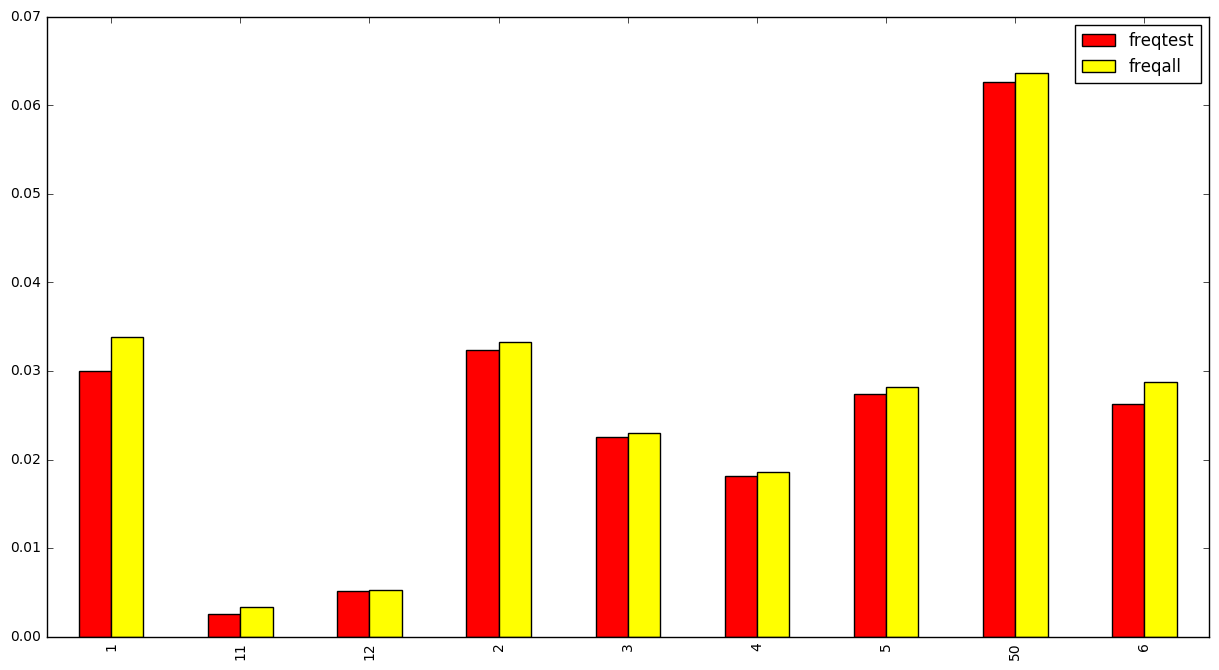

In [392]:
plot_distribution(best_testsplit_causal, regular_codes)

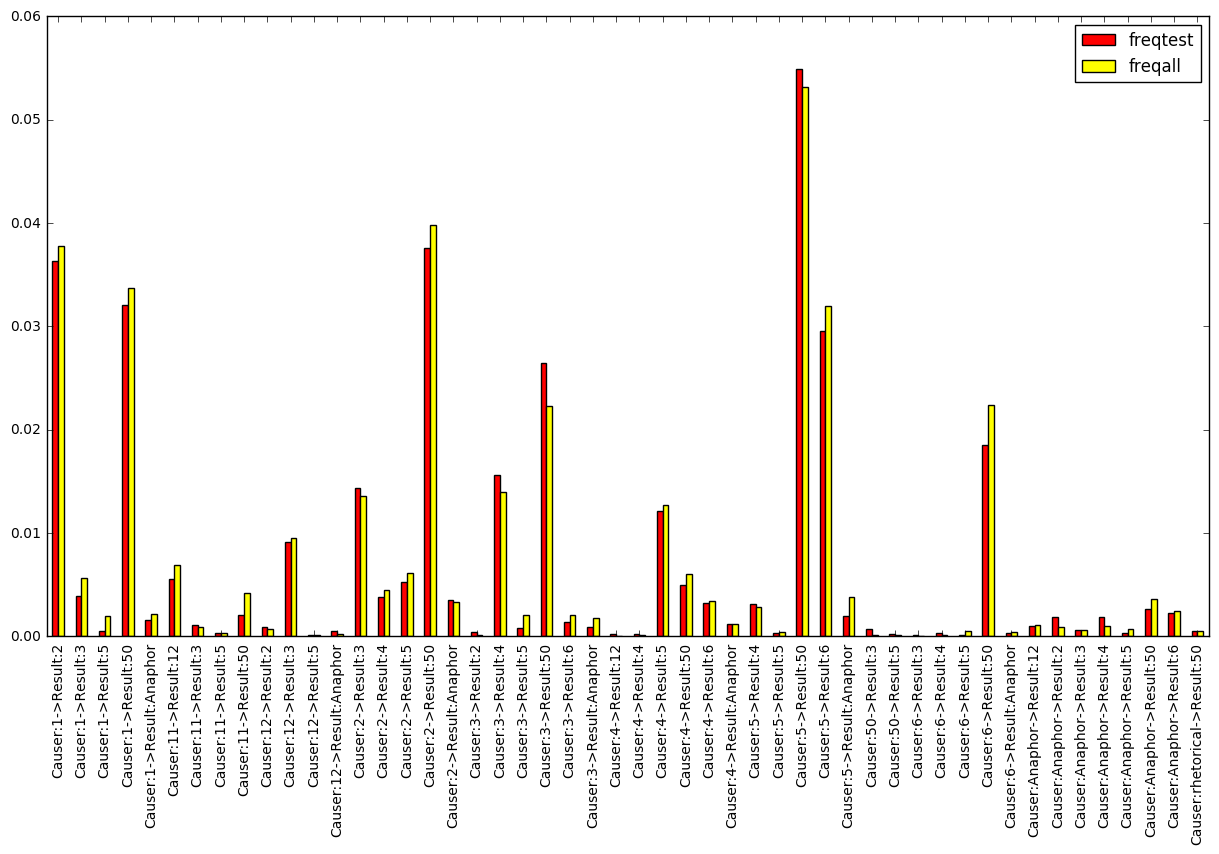

In [393]:
plot_distribution(best_testsplit_causal, causal_codes)

## Move The Files

In [394]:
import shutil

def copy_file(from_file, to_dir):
    to_file = os.path.join(to_dir, os.path.basename(from_file))
    if os.path.exists(to_file):
        print "File already exists: %s deleting" % to_file
        os.remove(to_file)
        shutil.copyfile(from_file, to_file)                    
    else:
        shutil.copyfile(from_file, to_file)

def copy_files(essays, to_dir):
    cnt = 0
    
    # Delete destination folder first
    if os.path.exists(to_dir):
        shutil.rmtree(to_dir, ignore_errors=True)
        
    os.mkdir(to_dir)
    
    ann_files = [e.full_path for e in essays]
    pairs = [joined[get_prefix(f)] for f in ann_files]
    
    for ann, txt in pairs:
        for a in ann:
            copy_file(a, to_dir)
        for t in txt:
            copy_file(t, to_dir)
        cnt += 2
             
    print "Moved %s files" % str(cnt)

In [401]:
copy_files(essays, all_folder)

Moved 2176 files


In [402]:
train, test = best_split_causal
copy_files(train, training_folder)
copy_files(test,  test_folder)

Moved 1740 files
Moved 436 files


In [403]:
452/2, n_test

(226, 218)

In [404]:
436/2, n_test

(218, 218)